In [1]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import logging

import jax
import jax.numpy as jnp

# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Get project paths correctly
current_dir = Path.cwd()
project_root = current_dir.parent  # diffCherenkov root (one level up from notebooks)
photonsim_root = project_root.parent / 'PhotonSim'  # PhotonSim root

# Add project paths
sys.path.insert(0, str(project_root))
sys.path.insert(0, str(project_root / 'tools'))

print(f"Current dir: {current_dir}")
print(f"Project root: {project_root}")
print(f"PhotonSim root: {photonsim_root}")

# Verify paths exist
print(f"Project root exists: {project_root.exists()}")
print(f"Siren dir exists: {(project_root / 'siren').exists()}")
print(f"Training dir exists: {(project_root / 'siren' / 'training').exists()}")
print(f"PhotonSim root exists: {photonsim_root.exists()}")

Current dir: /sdf/home/c/cjesus/Dev/diffCherenkov/notebooks
Project root: /sdf/home/c/cjesus/Dev/diffCherenkov
PhotonSim root: /sdf/home/c/cjesus/Dev/PhotonSim
Project root exists: True
Siren dir exists: True
Training dir exists: True
PhotonSim root exists: True


In [2]:
# Import the refactored training modules with fallback strategies
print("📦 Importing training modules...")

imported_successfully = False
        
try:
    training_path = project_root / 'siren' / 'training'
    if str(training_path) not in sys.path:
        sys.path.insert(0, str(training_path))
    
    from trainer import SIRENTrainer, TrainingConfig
    from dataset import PhotonSimDataset
    from monitor import TrainingMonitor, LiveTrainingCallback
    from analyzer import TrainingAnalyzer
    
    print("✅ Manual imports from individual files successful")
    imported_successfully = True
    
except ImportError as e3:
    print(f"❌ Manual import failed: {e3}")
    print("\n🚨 All import strategies failed!")
    print("Please check:")
    print(f"  1. Current working directory: {Path.cwd()}")
    print(f"  2. Project root: {project_root}")
    print(f"  3. Siren directory exists: {(project_root / 'siren').exists()}")
    print(f"  4. Training directory exists: {(project_root / 'siren' / 'training').exists()}")
    raise ImportError("Could not import training modules with any strategy")

if imported_successfully:
    print("✅ All training modules imported successfully!")
    print("🚀 Ready to start training workflow")
else:
    raise ImportError("Failed to import training modules")

📦 Importing training modules...


INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
INFO:numexpr.utils:NumExpr defaulting to 16 threads.


✅ Manual imports from individual files successful
✅ All training modules imported successfully!
🚀 Ready to start training workflow


In [3]:
# Set up output directory
output_dir = Path('output') / 'photonsim_siren_training'
output_dir.mkdir(exist_ok=True, parents=True)
model_save_dir = output_dir / 'trained_model'

In [4]:
import importlib
import sys

import importlib
if 'inference' in sys.modules:
  importlib.reload(sys.modules['inference'])
else:
  import inference
from inference import SIRENPredictor


# Import the inference module
sys.path.append(str(project_root / 'siren' / 'training'))
from inference import SIRENPredictor

# Load the saved model
model_base_path = model_save_dir / 'photonsim_siren'
predictor = SIRENPredictor(model_base_path)

print(f"✅ Model loaded successfully!")

# Test single prediction
energy = 500  # MeV
angle = np.radians(45)  # radians 
distance = 2000  # mm

density = predictor.predict(energy, angle, distance)
print(f"\n🔮 Single Prediction Test:")
print(f"  Input: E={energy} MeV, θ={np.degrees(angle):.1f}°, d={distance} mm")
print(f"  Predicted density: {density:.2e} photons/mm²")

# Test batch prediction
test_inputs = np.array([
    [400, np.radians(30), 1500],
    [500, np.radians(45), 2000], 
    [600, np.radians(60), 2500]
])

batch_densities = predictor.predict_batch(test_inputs)
print(f"\n📊 Batch Prediction Test:")
for i, (inp, dens) in enumerate(zip(test_inputs, batch_densities)):
    print(f"  Input {i+1}: E={inp[0]:.0f} MeV, θ={np.degrees(inp[1]):.1f}°, d={inp[2]:.0f} mm → {dens:.2e}")

# Display model info
info = predictor.get_info()
print(f"\n📋 Loaded Model Info:")
print(f"  Energy range: {info['dataset_info']['energy_range']} MeV")
print(f"  Angle range: {np.degrees(info['dataset_info']['angle_range'])} degrees")
print(f"  Distance range: {info['dataset_info']['distance_range']} mm")

INFO:2025-06-18 05:20:31,459:jax._src.xla_bridge:925: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-06-18 05:20:31,461:jax._src.xla_bridge:925: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:inference:Loaded SIREN model from output/photonsim_siren_training/trained_model/photonsim_siren
INFO:inference:Model config: {'hidden_features': 256, 'hidden_layers': 3, 'out_features': 1, 'w0': 30.0}
INFO:inference:Energy range: [100.0, 1000.0] MeV
INFO:inference:Angle range: [  0.18 179.82] degrees
INFO:inference:Distance range: [10.0, 9990.

✅ Model loaded successfully!

🔮 Single Prediction Test:
  Input: E=500 MeV, θ=45.0°, d=2000 mm
  Predicted density: 1.66e+00 photons/mm²

📊 Batch Prediction Test:
  Input 1: E=400 MeV, θ=30.0°, d=1500 mm → 4.91e+01
  Input 2: E=500 MeV, θ=45.0°, d=2000 mm → 1.65e+00
  Input 3: E=600 MeV, θ=60.0°, d=2500 mm → 3.37e-01

📋 Loaded Model Info:
  Energy range: [100.0, 1000.0] MeV
  Angle range: [  0.18 179.82] degrees
  Distance range: [10.0, 9990.0] mm


📊 Loaded lookup table with shape: (91, 500, 500)
  Energy range: 100 to 1000 MeV
  Angle range: 0.2 to 179.8 degrees
  Distance range: 10 to 9990 mm
\n🔍 Energy 200 MeV:
  Table range: 0.00e+00 to 6.38e+02
  SIREN range: 2.53e-03 to 3.39e+02
  SIREN/Table ratio: 1.43
\n🔍 Energy 400 MeV:
  Table range: 0.00e+00 to 8.35e+02
  SIREN range: 2.53e-03 to 4.05e+02
  SIREN/Table ratio: 1.06
\n🔍 Energy 600 MeV:
  Table range: 0.00e+00 to 9.16e+02
  SIREN range: 2.53e-03 to 6.32e+02
  SIREN/Table ratio: 1.05
\n🔍 Energy 800 MeV:
  Table range: 0.00e+00 to 9.70e+02
  SIREN range: 2.53e-03 to 8.69e+02
  SIREN/Table ratio: 1.03
\n🔍 Energy 1000 MeV:
  Table range: 0.00e+00 to 9.43e+02
  SIREN range: 2.53e-03 to 5.73e+02
  SIREN/Table ratio: 1.01


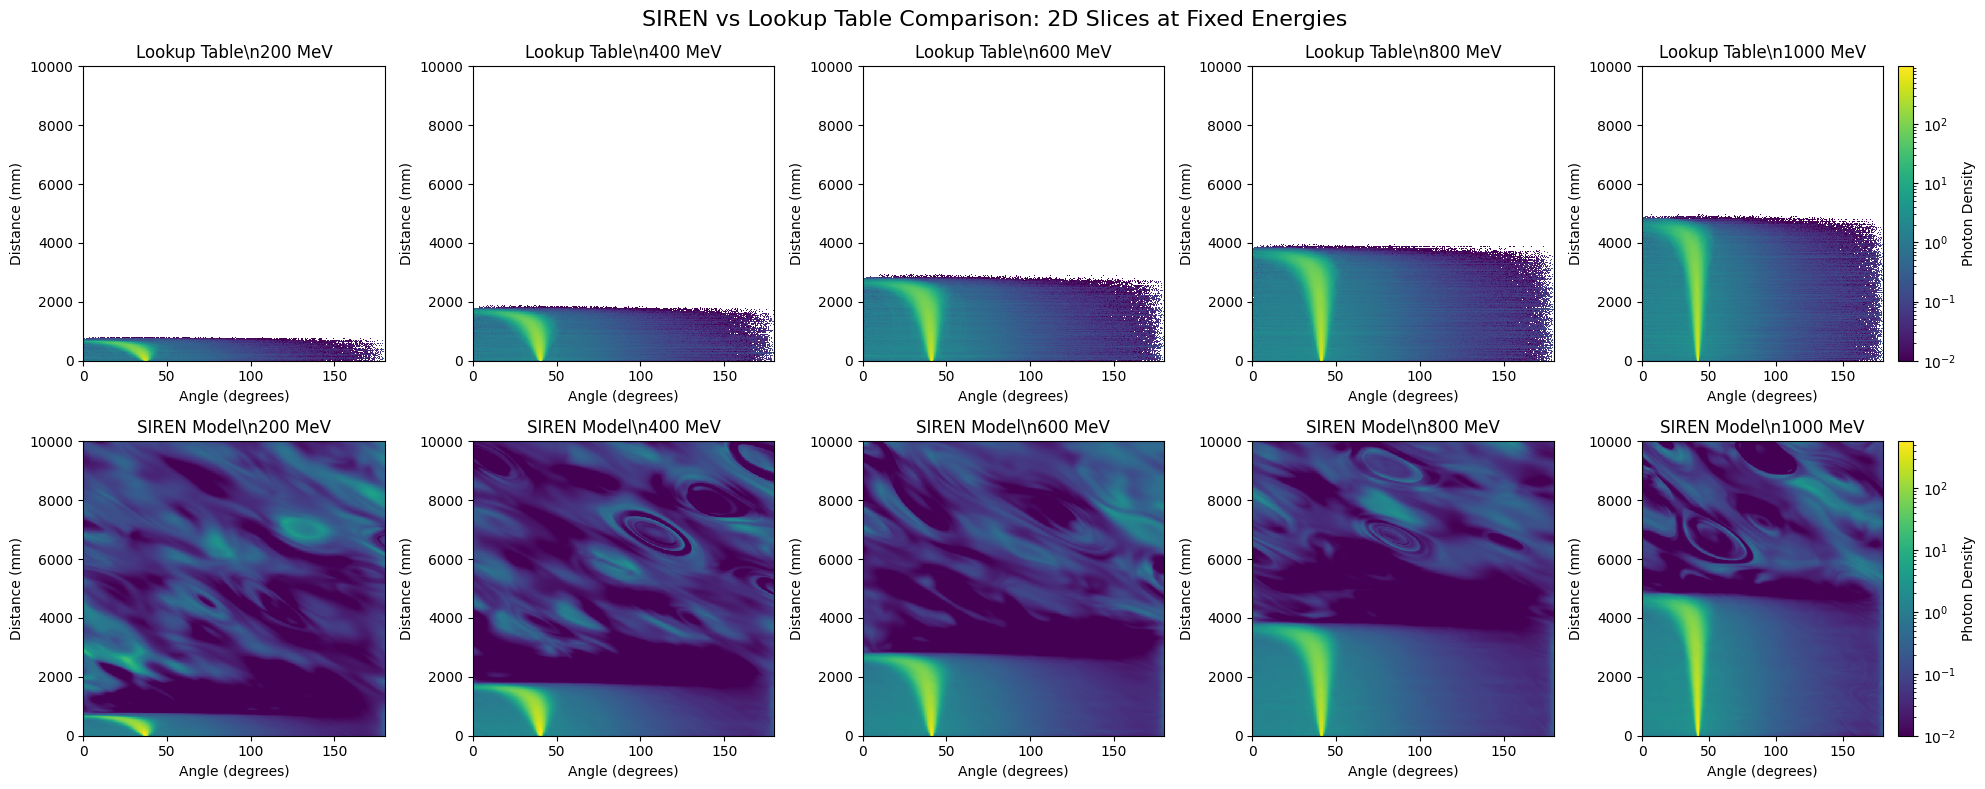

\n✅ Comparison plot saved to: output/photonsim_siren_training/siren_vs_lookup_comparison.png


In [5]:
# Load original lookup table for comparison
import h5py
from matplotlib.colors import LogNorm

# Define energies to compare
energies_to_plot = [200, 400, 600, 800, 1000]  # MeV

# Load the original HDF5 file
h5_path = photonsim_root / 'output' / 'photon_lookup_table.h5'

with h5py.File(h5_path, 'r') as f:
    # Load full density table and coordinates
    density_table = f['data/photon_table_density'][:]  # Shape: (n_energy, n_angle, n_distance)
    energy_centers = f['coordinates/energy_centers'][:]
    angle_centers = f['coordinates/angle_centers'][:]
    distance_centers = f['coordinates/distance_centers'][:]

print(f"📊 Loaded lookup table with shape: {density_table.shape}")
print(f"  Energy range: {energy_centers.min():.0f} to {energy_centers.max():.0f} MeV")
print(f"  Angle range: {np.degrees(angle_centers.min()):.1f} to {np.degrees(angle_centers.max()):.1f} degrees")
print(f"  Distance range: {distance_centers.min():.0f} to {distance_centers.max():.0f} mm")

# Create figure with 2 rows × 5 columns
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle('SIREN vs Lookup Table Comparison: 2D Slices at Fixed Energies', fontsize=16)

for i, energy in enumerate(energies_to_plot):
    # Find closest energy index in lookup table
    energy_idx = np.argmin(np.abs(energy_centers - energy))
    actual_energy = energy_centers[energy_idx]
    
    if np.abs(actual_energy - energy) > 100:  # Skip if too far
        axes[0, i].text(0.5, 0.5, f'No data near\\n{energy} MeV', 
                       ha='center', va='center', transform=axes[0, i].transAxes)
        axes[1, i].text(0.5, 0.5, f'No data near\\n{energy} MeV', 
                       ha='center', va='center', transform=axes[1, i].transAxes)
        continue
    
    # Get lookup table slice
    table_slice = density_table[energy_idx, :, :]  # Shape: (n_angle, n_distance)
    
    # Create SIREN prediction for the same grid
    angle_mesh, distance_mesh = np.meshgrid(angle_centers, distance_centers, indexing='ij')
    energy_grid = np.full_like(angle_mesh, actual_energy)
    
    # Stack coordinates for SIREN prediction
    eval_coords = np.stack([
        energy_grid.flatten(),
        angle_mesh.flatten(),
        distance_mesh.flatten()
    ], axis=-1)
    
    # Get SIREN predictions
    siren_predictions = predictor.predict_batch(eval_coords)
    siren_slice = siren_predictions.reshape(angle_mesh.shape)
    
    # Convert angles to degrees for plotting
    angle_mesh_deg = np.degrees(angle_mesh)
    
    # Plot lookup table (top row)
    ax_table = axes[0, i]
    
    # Use log scale for better visualization
    table_slice_plot = np.where(table_slice > 1e-10, table_slice, np.nan)
    im1 = ax_table.pcolormesh(angle_mesh_deg, distance_mesh, table_slice_plot, 
                             cmap='viridis', shading='auto',
                             norm=LogNorm(vmin=1e-2, vmax=table_slice.max()))
    
    ax_table.set_title(f'Lookup Table\\n{actual_energy:.0f} MeV')
    ax_table.set_xlabel('Angle (degrees)')
    ax_table.set_ylabel('Distance (mm)')
    
    if i == 4:  # Add colorbar to last plot
        cbar1 = plt.colorbar(im1, ax=ax_table)
        cbar1.set_label('Photon Density')
    
    # Plot SIREN predictions (bottom row)
    ax_siren = axes[1, i]
    
    siren_slice_plot = np.where(siren_slice > 1e-10, siren_slice, np.nan)
    im2 = ax_siren.pcolormesh(angle_mesh_deg, distance_mesh, siren_slice_plot, 
                             cmap='viridis', shading='auto',
                             norm=LogNorm(vmin=1e-2, vmax=siren_slice.max()))
    
    ax_siren.set_title(f'SIREN Model\\n{actual_energy:.0f} MeV')
    ax_siren.set_xlabel('Angle (degrees)')
    ax_siren.set_ylabel('Distance (mm)')
    
    if i == 4:  # Add colorbar to last plot
        cbar2 = plt.colorbar(im2, ax=ax_siren)
        cbar2.set_label('Photon Density')
    
    # Print comparison stats
    print(f"\\n🔍 Energy {actual_energy:.0f} MeV:")
    print(f"  Table range: {table_slice.min():.2e} to {table_slice.max():.2e}")
    print(f"  SIREN range: {siren_slice.min():.2e} to {siren_slice.max():.2e}")
    print(f"  SIREN/Table ratio: {siren_slice.mean()/table_slice.mean():.2f}")

plt.tight_layout()
plt.savefig(output_dir / 'siren_vs_lookup_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\\n✅ Comparison plot saved to: {output_dir / 'siren_vs_lookup_comparison.png'}")

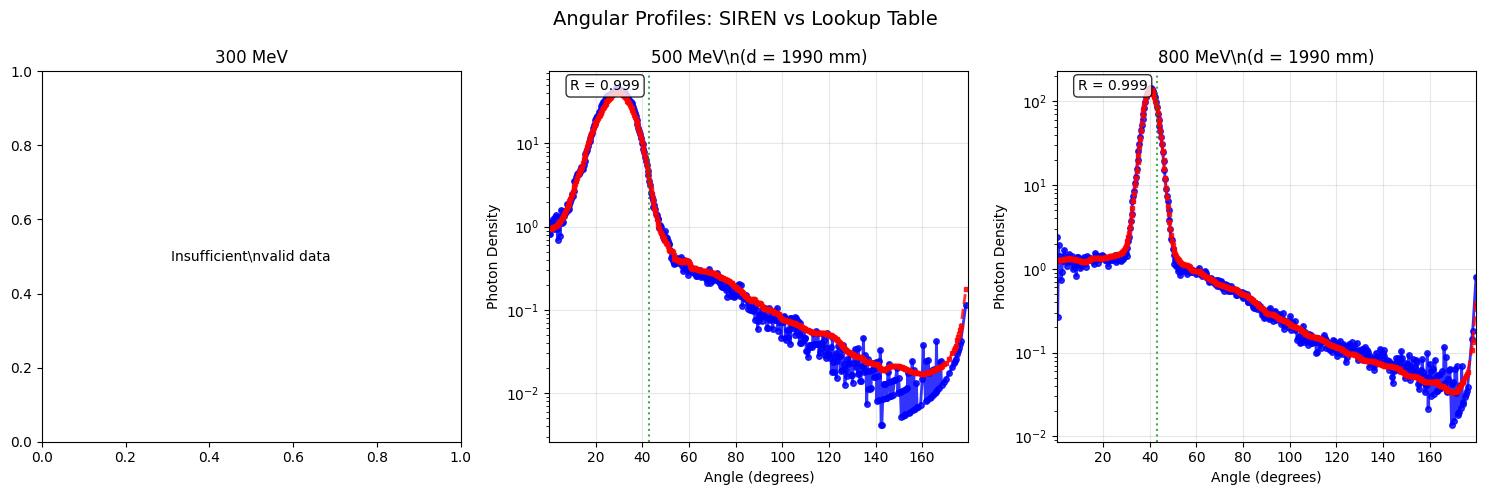

✅ Angular profile comparison saved to: output/photonsim_siren_training/angular_profile_comparison.png


In [6]:
# Create angular profile comparison plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Angular Profiles: SIREN vs Lookup Table', fontsize=14)

energies_for_profiles = [300, 500, 800]
fixed_distance = 2000  # mm

for i, energy in enumerate(energies_for_profiles):
    ax = axes[i]
    
    # Find closest energy in lookup table
    energy_idx = np.argmin(np.abs(energy_centers - energy))
    actual_energy = energy_centers[energy_idx]
    
    if np.abs(actual_energy - energy) > 100:
        ax.text(0.5, 0.5, f'No data near\\n{energy} MeV', 
               ha='center', va='center', transform=ax.transAxes)
        continue
    
    # Find closest distance index
    distance_idx = np.argmin(np.abs(distance_centers - fixed_distance))
    actual_distance = distance_centers[distance_idx]
    
    # Get lookup table angular profile at this energy and distance
    table_profile = density_table[energy_idx, :, distance_idx]
    
    # Create SIREN predictions for same points
    coords_1d = np.array([[actual_energy, angle, actual_distance] for angle in angle_centers])
    siren_profile = predictor.predict_batch(coords_1d)
    
    # Convert angles to degrees for plotting
    angles_deg = np.degrees(angle_centers)
    
    # Plot both profiles
    valid_mask = (table_profile > 1e-10) & (siren_profile > 1e-10)
    
    if np.sum(valid_mask) > 5:
        ax.plot(angles_deg[valid_mask], table_profile[valid_mask], 
               'o-', alpha=0.8, label='Lookup Table', markersize=4, linewidth=2, color='blue')
        ax.plot(angles_deg[valid_mask], siren_profile[valid_mask], 
               's--', alpha=0.8, label='SIREN Model', markersize=3, linewidth=2, color='red')
        
        # Mark Cherenkov angle (approximately 43 degrees for water)
        ax.axvline(43, color='green', linestyle=':', alpha=0.7, label='Cherenkov angle')
        
        ax.set_xlabel('Angle (degrees)')
        ax.set_ylabel('Photon Density')
        ax.set_title(f'{actual_energy:.0f} MeV\\n(d = {actual_distance:.0f} mm)')
        ax.set_yscale('log')
        ax.set_xlim(angles_deg.min(), angles_deg.max())
        ax.grid(True, alpha=0.3)
        
        if i == 0:  # Show legend only on first plot
            ax.legend()
        
        # Calculate and display correlation
        from scipy.stats import pearsonr
        corr, _ = pearsonr(table_profile[valid_mask], siren_profile[valid_mask])
        ax.text(0.05, 0.95, f'R = {corr:.3f}', transform=ax.transAxes,
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    else:
        ax.text(0.5, 0.5, 'Insufficient\\nvalid data', ha='center', va='center', 
               transform=ax.transAxes)
        ax.set_title(f'{energy} MeV')

plt.tight_layout()
plt.savefig(output_dir / 'angular_profile_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Angular profile comparison saved to: {output_dir / 'angular_profile_comparison.png'}")